## Abstract
Despite the fact that the agricultural sector is a national economic development priority in sub-Saharan Africa, crop pests and diseases have been the challenge affecting major food security crops like maize. 
Maize Streak Disease which is caused by the Maize Streak Virus is regarded as the third most serious disease affecting maize in sub-Saharan Africa. 
The prominence of this disease has greatly affected the yields of Africa’s most important food crop. 

## Classes
<div style="display: flex; justify-content: center;">
    <div style="text-align: center; margin-right: 20px;">
        <p>Healthy</p>
        <img src="sample/1621590060253.jpg" alt="Image 1" style="width: 200;">
    </div>
    <div style="text-align: center;">
        <p>Maize Streak Disease</p>
        <img src="sample/1621319276554.jpg" alt="Image 2" style="width: 200;">
    </div>
</div>


In [1]:
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras
import numpy as np
import os
import json
import mlflow
import mlflow.keras
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2024-04-26 10:38:53.022479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 10:38:53.465055: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 10:38:53.468731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 10:38:56.354092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/kalema/anaconda3/envs/kidney/lib/python3.8/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.

In [2]:
# params
params = {
    "LEARNING_RATE": 0.01,
    "CLASSES": 2,
    "EPOCHS": 6,
    "INCLUDE_TOP": False,
    "BATCH_SIZE": 16,
    "WEIGHTS": "imagenet",
    "IMAGE_SIZE": [224, 224, 3],
    "DECAY": 1e-6,
    "MOMENTUM": 0.9
}

# mlflow configs
MLFLOW_TRACKING_URI = "https://dagshub.com/kalema3502/vggnet-transfer-learning-for-msv.mlflow"
MLFLOW_TRACKING_USERNAME = "kalema3502"
MLFLOW_TRACKING_PASSWORD = "fb3845efcc3b2e46a4157b1d2c977a21e02dd16e"

In [3]:
# data path
DATA = "data/"

In [4]:
# base model
base_model = VGG16(input_shape=params['IMAGE_SIZE'], weights=params['WEIGHTS'], include_top=params['INCLUDE_TOP'])


In [5]:
# base model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# freeze hidden layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# create custom output(dense) layer
output = Dense(params['CLASSES'], activation="softmax") (Flatten() (base_model.output))

In [25]:
# custom model
new_model = Model(inputs=base_model.input, outputs=output)
new_model.compile(
            optimizer=optimizers.SGD(learning_rate=params['LEARNING_RATE'], decay=params['DECAY'], momentum=params['MOMENTUM']),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [9]:
# Augmentation
datagenerator_kwargs = dict(
            rescale=1./255,
            validation_split=0.20
        )
dataflow_kwargs = dict(
            target_size=params['IMAGE_SIZE'][:-1],
            batch_size=params['BATCH_SIZE'],
            interpolation="bilinear"
        )
train_datagenerator = ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=20,
                height_shift_range=20,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
validation_datagenerator = ImageDataGenerator(
               **datagenerator_kwargs
            )



In [10]:
# train test sets
train_set = train_datagenerator.flow_from_directory(
            directory=DATA,
            subset='training',
            shuffle=True,
            class_mode="categorical",
            **dataflow_kwargs
        )
validation_set = validation_datagenerator.flow_from_directory(
            directory=DATA,
            subset='validation',
            shuffle=True,
            class_mode="categorical",
            **dataflow_kwargs
        )

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [11]:
# training
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('artifacts/', exist_ok=True)

steps_per_epoch = train_set.samples // train_set.batch_size
validation_steps = validation_set.samples // validation_set.batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-5)

checkpoint = ModelCheckpoint(filepath='artifacts/model.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_reducer]
start = datetime.now()

new_model.fit_generator(generator=train_set,
                        validation_data=validation_set,
                        epochs=params['EPOCHS'],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=callbacks,
                        verbose=1)

duration = datetime.now() - start
print(f"Training completed in time: {duration}")

/tmp/ipykernel_7596/473648849.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(generator=train_set,


Epoch 1/6


2024-04-26 10:39:11.994606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-26 10:39:14.443820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-04-26 10:39:14.808847: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-04-26 10:39:15.963039: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2024-04-26 10:39:16.073213: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-04-26 10:39:16.640392: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10

60/60 [==============================] - ETA: 0s - loss: 22.5880 - accuracy: 0.6865

2024-04-26 10:47:01.468686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 14.53261, saving model to artifacts/model.h5
60/60 [==============================] - 577s 10s/step - loss: 22.5880 - accuracy: 0.6865 - val_loss: 14.5326 - val_accuracy: 0.6750 - lr: 0.0100
Epoch 2/6
60/60 [==============================] - ETA: 0s - loss: 2.4998 - accuracy: 0.9219
Epoch 2: val_loss improved from 14.53261 to 1.79749, saving model to artifacts/model.h5
60/60 [==============================] - 542s 9s/step - loss: 2.4998 - accuracy: 0.9219 - val_loss: 1.7975 - val_accuracy: 0.9292 - lr: 0.0100
Epoch 3/6
60/60 [==============================] - ETA: 0s - loss: 2.4660 - accuracy: 0.9146
Epoch 3: val_loss did not improve from 1.79749
60/60 [==============================] - 543s 9s/step - loss: 2.4660 - accuracy: 0.9146 - val_loss: 3.4144 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 4/6
60/60 [==============================] - ETA: 0s - loss: 2.3934 - accuracy: 0.9240
Epoch 4: val_loss did not improve from 1.79749
60/60 [===============

In [24]:

plt.plot(new_model.history.history['accuracy'])
plt.plot(new_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.savefig('accuracy.png')
plt.show()


AttributeError: 'NoneType' object has no attribute 'history'

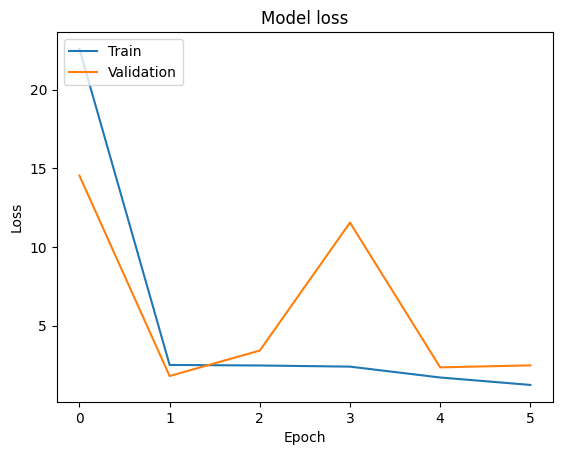

In [20]:
plt.plot(new_model.history.history['loss'])
plt.plot(new_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [12]:
# model evaluation
best_model = load_model('artifacts/model.h5')

results = best_model.evaluate(validation_set)

scores = {'loss': results[0], 'accuracy': results[1]}

try:
    with open('scores.json', 'w') as json_file:
        json.dump(scores, json_file)
except IOError as e:
    raise IOError(f"An error occurred while writing to the file: {e}")

2024-04-26 11:39:37.384152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


15/15 [==============================] - 119s 8s/step - loss: 1.7975 - accuracy: 0.9292


In [13]:
# mlflow configs
os.environ["MLFLOW_TRACKING_URI"]= MLFLOW_TRACKING_URI
os.environ["MLFLOW_TRACKING_USERNAME"]= MLFLOW_TRACKING_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"]= MLFLOW_TRACKING_PASSWORD

In [14]:
# experiment tracking
mlflow.set_registry_uri(MLFLOW_TRACKING_URI)
tracking_url_type_store= urlparse(mlflow.get_tracking_uri()).scheme

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics(
        {"loss": results[0], "accuracy": results[1]}
    )
    
    if tracking_url_type_store != "file":
        mlflow.keras.log_model(best_model, "model", registered_model_name="VGG16Model")
    else:
        mlflow.keras.log_model(best_model, "model")

2024/04/26 11:41:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpk_4icp1a/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk_4icp1a/model/data/model/assets
/home/kalema/anaconda3/envs/kidney/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'VGG16Model' already exists. Creating a new version of this model...
2024/04/26 11:45:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: VGG16Model, version 3
Created version '3' of model 'VGG16Model'.
